In [25]:
import os
import cv2
import json
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import albumentations as A
import torch.optim as optim
from torchinfo import summary
import torchmetrics as metrics
import lightning.pytorch as pl
import torch.nn.functional as f
import matplotlib.pyplot as plt
from PIL import Image, ImageColor
import torchvision.utils as utils
from models import UNet
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2
import torchvision.transforms.functional as tf
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import LearningRateMonitor
from torch.utils.data import DataLoader, Dataset, random_split
from models.diceScore import dice_loss, multiclass_dice_coef
from torchmetrics.functional.classification import multilabel_precision, multilabel_recall

In [26]:
colors = [
    (255, 255, 255), # Background (white)
    (102, 255, 51),    # Normal (blue)
    (51, 255, 153),  # Polyp (cyanic green)
    (204, 255, 51),  # Serrated adenoma (yelowish green)
    (255, 255, 0),  # Low-grade IN (yellow)
    (255, 153, 0), # High-grade IN (orange)
    (204, 51, 0), # Adenocarcinoma (red)
]

## Data Preps (System)

In [27]:
trainDf = pd.read_csv('traindata.csv')
valDf = pd.read_csv('valdata.csv')
testDf = pd.read_csv('testdata.csv')

In [28]:
trainDf['Path'] = trainDf['Path'].str.strip()


In [29]:
trainDf

,Path
0,EBHI-SEG/Polyp/image/GTXC2110503-1-400-002.png
1,EBHI-SEG/Low-grade IN/image/GTDC2101366-1-400-...
2,EBHI-SEG/Adenocarcinoma/image/GTXC2012151-2-40...
3,EBHI-SEG/Polyp/image/GT2012191-1-400-002.png
4,EBHI-SEG/Adenocarcinoma/image/GTXC2015349-2-40...
...,...
1553,EBHI-SEG/Normal/image/GT2100144-1-400-004.png
1554,EBHI-SEG/Adenocarcinoma/image/GTXC2110135-2-40...
1555,EBHI-SEG/Adenocarcinoma/image/GT2001849-1-400-...
1556,EBHI-SEG/Adenocarcinoma/image/GTXC2015413-3-40...


In [30]:
# Mendefinisikan direktori utama data
dataDir = Path('EBHI-SEG')

# Mendapatkan daftar nama kelas (subdirektori) dari direktori utama
classNames = [classes for classes in os.listdir(dataDir) if os.path.isdir(os.path.join(dataDir, classes))]

# Inisialisasi daftar untuk menyimpan informasi gambar, label, kelas, dan pemisahan data
imageList = []
labelList = []
classList = []
splitClass = []

# Mengambil daftar jalur (path) gambar untuk pelatihan, validasi, dan pengujian
trainList = trainDf['Path'].tolist()
valList = valDf['Path'].tolist()
testList = testDf['Path'].tolist()

# Iterasi melalui setiap kelas
for className in classNames:
    # Membuat jalur lengkap ke direktori kelas
    classDir = os.path.join(dataDir, className)
    
    # Membuat jalur lengkap ke direktori gambar dan label dalam kelas
    imageDir = os.path.join(classDir, 'image')
    labelDir = os.path.join(classDir, 'label')
    
    # Mendapatkan daftar nama file gambar dan label dalam direktori
    imagePath = [file for file in os.listdir(imageDir)]
    labelPath = [file for file in os.listdir(labelDir)]
    
    # Iterasi melalui setiap gambar dalam kelas
    for img in imagePath:
        # Jika terdapat label yang sesuai dengan gambar
        if img in labelPath:
            # Simpan jalur lengkap ke gambar dan label
            imageList.append(os.path.join(imageDir, img))
            labelList.append(os.path.join(labelDir, img))
            
            # Simpan nama kelas dari gambar
            classList.append(className)
            
            # Tentukan apakah gambar ini digunakan untuk pelatihan, validasi, atau pengujian
            if os.path.join(imageDir, img) in trainList:
                splitClass.append('train')
            elif os.path.join(imageDir, img) in valList:
                splitClass.append('validation')
            else:
                splitClass.append('testing')


In [31]:
df = pd.DataFrame({'image' : imageList, 'label' : labelList, 'class' : classList, 'split' : splitClass})

In [32]:
df['split'].unique()

array(['train', 'testing', 'validation'], dtype=object)

In [33]:
for folder in dataDir.iterdir():
    if folder.is_dir():
        for folder2 in folder.iterdir():
            if folder2.is_dir():
                print(folder.name)
                print(folder2.name)
                print(len(os.listdir(folder2)))

Low-grade IN
label
637
Low-grade IN
image
639
Adenocarcinoma
label
795
Adenocarcinoma
image
795
High-grade IN
label
186
High-grade IN
image
186
Normal
label
76
Normal
image
76
Polyp
label
474
Polyp
image
474
Serrated adenoma
label
58
Serrated adenoma
image
58


In [34]:
df.to_csv('imageLabel.csv', index=False)

## Data Preps

In [35]:
df = pd.read_csv('imageLabel.csv')
df

,image,label,class,split
0,EBHI-SEG/Low-grade IN/image/GTXC2014165-2-400-...,EBHI-SEG/Low-grade IN/label/GTXC2014165-2-400-...,Low-grade IN,train
1,EBHI-SEG/Low-grade IN/image/GTXC2015407-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015407-1-400-...,Low-grade IN,train
2,EBHI-SEG/Low-grade IN/image/GTxc2012481-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012481-1-400-...,Low-grade IN,train
3,EBHI-SEG/Low-grade IN/image/GTxc2014132-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2014132-1-400-...,Low-grade IN,train
4,EBHI-SEG/Low-grade IN/image/GTxc2012967-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012967-1-400-...,Low-grade IN,train
...,...,...,...,...
2221,EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...,EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...,Serrated adenoma,train
2222,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train
2223,EBHI-SEG/Serrated adenoma/image/GT2016855-1-40...,EBHI-SEG/Serrated adenoma/label/GT2016855-1-40...,Serrated adenoma,testing
2224,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train


In [36]:
df[df['split'] == 'train']

,image,label,class,split
0,EBHI-SEG/Low-grade IN/image/GTXC2014165-2-400-...,EBHI-SEG/Low-grade IN/label/GTXC2014165-2-400-...,Low-grade IN,train
1,EBHI-SEG/Low-grade IN/image/GTXC2015407-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015407-1-400-...,Low-grade IN,train
2,EBHI-SEG/Low-grade IN/image/GTxc2012481-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012481-1-400-...,Low-grade IN,train
3,EBHI-SEG/Low-grade IN/image/GTxc2014132-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2014132-1-400-...,Low-grade IN,train
4,EBHI-SEG/Low-grade IN/image/GTxc2012967-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012967-1-400-...,Low-grade IN,train
...,...,...,...,...
2220,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train
2221,EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...,EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...,Serrated adenoma,train
2222,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train
2224,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train


In [37]:
df[df['split'] == 'validation']

,image,label,class,split
20,EBHI-SEG/Low-grade IN/image/GTXC2015417-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015417-1-400-...,Low-grade IN,validation
23,EBHI-SEG/Low-grade IN/image/GTxc2012468-2-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012468-2-400-...,Low-grade IN,validation
25,EBHI-SEG/Low-grade IN/image/GTxc2013458-2-400-...,EBHI-SEG/Low-grade IN/label/GTxc2013458-2-400-...,Low-grade IN,validation
29,EBHI-SEG/Low-grade IN/image/GTxc2013943-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2013943-1-400-...,Low-grade IN,validation
30,EBHI-SEG/Low-grade IN/image/GTXC2015407-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015407-1-400-...,Low-grade IN,validation
...,...,...,...,...
2203,EBHI-SEG/Serrated adenoma/image/GTXC2014129-4-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-4-...,Serrated adenoma,validation
2206,EBHI-SEG/Serrated adenoma/image/GTXC2014129-4-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-4-...,Serrated adenoma,validation
2212,EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...,EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...,Serrated adenoma,validation
2216,EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...,EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...,Serrated adenoma,validation


In [38]:
df[df['split'] == 'testing']

,image,label,class,split
13,EBHI-SEG/Low-grade IN/image/GTxc2012960-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012960-1-400-...,Low-grade IN,testing
18,EBHI-SEG/Low-grade IN/image/GTXC2015362-3-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015362-3-400-...,Low-grade IN,testing
39,EBHI-SEG/Low-grade IN/image/GTXC2015383-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015383-1-400-...,Low-grade IN,testing
48,EBHI-SEG/Low-grade IN/image/GTXC2014139-5-400-...,EBHI-SEG/Low-grade IN/label/GTXC2014139-5-400-...,Low-grade IN,testing
49,EBHI-SEG/Low-grade IN/image/GTXC2014139-5-400-...,EBHI-SEG/Low-grade IN/label/GTXC2014139-5-400-...,Low-grade IN,testing
...,...,...,...,...
2157,EBHI-SEG/Polyp/image/GTxc2013935-1-400-004.png,EBHI-SEG/Polyp/label/GTxc2013935-1-400-004.png,Polyp,testing
2159,EBHI-SEG/Polyp/image/GT2013108-1-400-001.png,EBHI-SEG/Polyp/label/GT2013108-1-400-001.png,Polyp,testing
2190,EBHI-SEG/Serrated adenoma/image/GTXC2014151-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014151-2-...,Serrated adenoma,testing
2215,EBHI-SEG/Serrated adenoma/image/GTxc2014069-2-...,EBHI-SEG/Serrated adenoma/label/GTxc2014069-2-...,Serrated adenoma,testing


In [39]:
classes = {
    'Normal' : 1,
    'Polyp' : 2,
    'Low-grade IN' : 4,
    'High-grade IN' : 5,
    'Serrated adenoma' : 3,
    'Adenocarcinoma' : 6
}

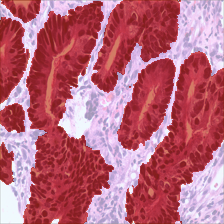

In [40]:
randidx = np.random.randint(0, len(df))
# Tampilkan salah satu gambar
colorMap = np.array(colors, dtype=np.uint8)
img = Image.open(df.iloc[randidx,0])
lbl = np.array(Image.open(df.iloc[randidx,1]))
lblBin = (lbl > 0).astype(np.uint8) * classes[df.iloc[randidx,2]]
coloredBin = Image.fromarray(colorMap[lblBin]).convert('RGB')
overlay = Image.blend(img, coloredBin, alpha=.6)
overlay

In [41]:
df['class'].unique()

array(['Low-grade IN', 'Adenocarcinoma', 'High-grade IN', 'Normal',
       'Polyp', 'Serrated adenoma'], dtype=object)

In [47]:
# Definisikan dataset khusus EBHI
class EBHIDataset(Dataset):
    def __init__(self, imageList, labelList, classList, classDict, transforms=None):
        # Pastikan panjang semua daftar sama
        assert len(imageList) == len(labelList) and len(imageList) == len(classList) and len(labelList) == len(classList), '3 of the lists are not the same length'
        
        # Inisialisasi atribut dataset
        self.imageList = imageList
        self.labelList = labelList
        self.classList = classList
        self.classDict = classDict
        self.transforms = transforms

    def __len__(self):
        # Mengembalikan panjang dataset
        return len(self.imageList)

    def __getitem__(self, index):
        # Memuat citra dan mask dari file gambar
        image = np.array(Image.open(self.imageList[index]))
        mask = np.array(Image.open(self.labelList[index]))
        
        # Menerapkan pemrosesan mask berdasarkan classDict
        mask = (mask > 0).astype(np.uint8) * self.classDict[self.classList[index]]
        
        # Jika terdapat transformasi yang diberikan
        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            imgAug = transformed['image'].contiguous()
            maskAug = transformed['mask'].contiguous()
            return imgAug, maskAug
        
        # Konversi citra dan mask menjadi tensor PyTorch
        image = torch.as_tensor(image).float().contiguous()
        mask = torch.as_tensor(mask).long().contiguous()
        return image, mask

# Definisikan modul pengelolaan data khusus
class dataModule(pl.LightningDataModule):
    def __init__(self, df, classDict, batchSize):
        super().__init__()
        self.df = df
        self.batchSize = batchSize
        self.classDict = classDict

    def prepare_data(self):
        # Tidak ada unduhan data, sehingga kita lewatkan tahap ini
        pass

    def _getTransform(self, train=True):
        # Mendefinisikan transformasi data menggunakan Albumentations
        if train:
            return A.Compose([
                A.OneOf([
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                    A.RandomRotate90(),
                ], p=0.5),
                ToTensorV2()
            ])
        else:
            return A.Compose([
                ToTensorV2()
            ])

    def setup(self, stage: str):
        # Mempersiapkan dataset pelatihan, validasi, dan pengujian
        trainTransform = self._getTransform()
        valTransform = self._getTransform(False)
        
        self.trainingSet = EBHIDataset(
            self.df[self.df['split'] == 'train']['image'].tolist(),
            self.df[self.df['split'] == 'train']['label'].tolist(),
            self.df[self.df['split'] == 'train']['class'].tolist(),
            classDict=self.classDict,
            transforms=trainTransform
        )
        
        self.valSet = EBHIDataset(
            self.df[self.df['split'] == 'validation']['image'].tolist(),
            self.df[self.df['split'] == 'validation']['label'].tolist(),
            self.df[self.df['split'] == 'validation']['class'].tolist(),
            classDict=self.classDict,
            transforms=valTransform
        )
        
        self.testSet = EBHIDataset(
            self.df[self.df['split'] == 'testing']['image'].tolist(),
            self.df[self.df['split'] == 'testing']['label'].tolist(),
            self.df[self.df['split'] == 'testing']['class'].tolist(),
            classDict=self.classDict,
            transforms=valTransform
        )

    # def train_dataloader(self):
    #     # Mengembalikan iterator pelatihan
    #     return DataLoader(self.trainingSet, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True, shuffle=True)

    # def val_dataloader(self):
    #     # Mengembalikan iterator validasi
    #     return DataLoader(self.valSet, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True, shuffle=False)

    # def predict_dataloader(self):
    #     # Mengembalikan iterator pengujian
    #     return DataLoader(self.testSet, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True, shuffle=False)
    def train_dataloader(self):
        # Mengembalikan iterator pelatihan
        return DataLoader(self.trainingSet, batch_size=self.batchSize, drop_last=True, pin_memory=True, shuffle=True)

    def val_dataloader(self):
        # Mengembalikan iterator validasi
        return DataLoader(self.valSet, batch_size=self.batchSize, drop_last=True, pin_memory=True, shuffle=False)

    def predict_dataloader(self):
        # Mengembalikan iterator pengujian
        return DataLoader(self.testSet, batch_size=self.batchSize, drop_last=True, pin_memory=True, shuffle=False)

In [48]:
model = UNet(n_channels=3, n_classes=7, init_filter=8)
summary(model, input_size=(1,3,256,256))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 7, 256, 256]          --
├─DoubleConv: 1-1                             [1, 8, 256, 256]          --
│    └─Sequential: 2-1                        [1, 8, 256, 256]          --
│    │    └─Conv2d: 3-1                       [1, 8, 256, 256]          216
│    │    └─BatchNorm2d: 3-2                  [1, 8, 256, 256]          16
│    │    └─ReLU: 3-3                         [1, 8, 256, 256]          --
│    │    └─Conv2d: 3-4                       [1, 8, 256, 256]          576
│    │    └─BatchNorm2d: 3-5                  [1, 8, 256, 256]          16
│    │    └─ReLU: 3-6                         [1, 8, 256, 256]          --
├─Down: 1-2                                   [1, 16, 128, 128]         --
│    └─Sequential: 2-2                        [1, 16, 128, 128]         --
│    │    └─MaxPool2d: 3-7                    [1, 8, 128, 128]          --
│    │    └─Double

In [49]:

# Definisikan modul UNet
class UNetModule(pl.LightningModule):
    def __init__(self, nClasses=7, lr=0.01, decay=0):
        super().__init__()
        # Inisialisasi model U-Net
        self.model = UNet(n_channels=3, n_classes=nClasses)
        self.nClasses = nClasses
        self.lr = lr
        self.decay = decay
        self.save_hyperparameters()
        # Menggunakan fungsi kerugian CrossEntropy
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # Meneruskan data melalui model U-Net
        logits = self.model(x)
        return logits

    def training_step(self, batch, batch_idx):
        # Pelatihan satu langkah
        img, mask = batch
        img = img.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
        mask = mask.to(device=self.device, dtype=torch.long)
        predMask = self.forward(img)
        loss = self.criterion(predMask, mask)
        
        # Menambahkan dice loss ke dalam kerugian
        loss += dice_loss(f.softmax(predMask, dim=1).float(), f.one_hot(mask, self.nClasses).permute(0, 3, 1, 2).float(), multiclass=True)
        
        # Log kerugian dice
        self.log('diceLoss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Langkah validasi
        img, mask = batch
        totalN = self.trainer.num_val_batches[0]
        img = img.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
        mask = mask.to(device=self.device, dtype=torch.long)
        assert mask.min() >= 0 and mask.max() < self.nClasses, f'True mask indices should be in [0, {self.nClasses}]'
        predMask = self.forward(img)
        mask = f.one_hot(mask, self.nClasses).permute(0, 3, 1, 2).float()
        predMask = f.one_hot(predMask.argmax(dim=1), self.nClasses).permute(0, 3, 1, 2).float()
        
        # Menghitung dice score
        diceScore = multiclass_dice_coef(predMask[:, 1:], mask[:, 1:], reduce_batch_first=False)
        
        # Log skor dice
        self.log('diceScore', diceScore, on_step=False, on_epoch=True, prog_bar=True, reduce_fx=torch.mean)
        return diceScore

    def predict_step(self, batch, batch_idx):
        # Langkah prediksi
        img, mask = batch
        img = img.to(device=self.device, dtype=torch.float32)
        outputs = self.forward(img)
        predMask = outputs.argmax(dim=1)

        mask = f.one_hot(mask.long(), self.nClasses).permute(0, 3, 1, 2).float()
        predictionMask = f.one_hot(predMask.cpu(), self.nClasses).permute(0, 3, 1, 2).float()

        return img, predMask.long().squeeze().cpu().numpy(), mask, predictionMask

    def configure_optimizers(self):
        # Konfigurasi optimizer dan scheduler
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min')
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'diceLoss'
            }
        }
        # return optimizer

In [50]:
dataMod = dataModule(df=df, classDict=classes, batchSize=1)
model = UNetModule(lr=0.01)
lrMonitor = LearningRateMonitor(logging_interval='epoch')
logger = TensorBoardLogger('tb_logs', name='UNetSegm')
trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=10, logger=logger, callbacks=[lrMonitor])
trainer.fit(model=model, datamodule=dataMod)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UNet             | 31.0 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.152   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/mhihsan/miniconda3/envs/indonesiaai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/mhihsan/miniconda3/envs/indonesiaai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/Users/mhihsan/miniconda3/envs/indonesiaai/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
